# Auto Encoders and Variational Auto Encoders on MNIST

In this notebook we are going to demonstrate Auto Encoder and Variational Auto Encoder models on MNIST data.  

We will go through many visualizations to develop good intuition on how these models work.

In [1]:
# Python lib
from typing import List, Tuple

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Vizualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Globals

In [2]:
DATA_DIR = 'data'

BATCH_SIZE = 128

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [3]:
def get_mnist_ds(train: bool):

    return torchvision.datasets.MNIST(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                ]), 
                                      target_transform=None, 
                                      download=True)

def get_mnist_dls():
    
    train_ds = get_mnist_ds(train=True)
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False))

train_dl, valid_dl = get_mnist_dls()

len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

torch.Size([128, 1, 28, 28]) tensor(0.1333) tensor(0.3111) tensor(0.) tensor(1.)


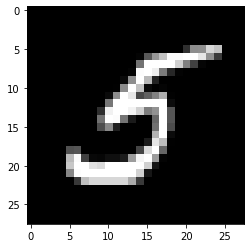

torch.Size([128, 1, 28, 28]) tensor(0.1235) tensor(0.2996) tensor(0.) tensor(1.)


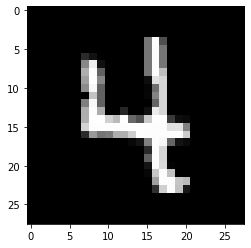

torch.Size([128, 1, 28, 28]) tensor(0.1288) tensor(0.3060) tensor(0.) tensor(1.)


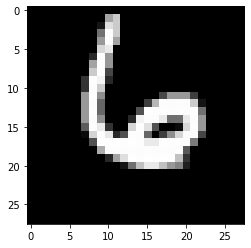

torch.Size([128, 1, 28, 28]) tensor(0.1324) tensor(0.3099) tensor(0.) tensor(1.)


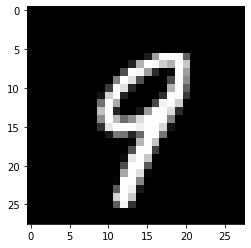

In [4]:
# displaying some of the images with some stats. 

for i, (x, y) in enumerate(train_dl):
    print(x.shape, x.mean(), x.std(), x.min(), x.max())
    plt.imshow(x[0][0], cmap='gray')
    plt.show()
    if i > 2: break

## Training Vanilla Auto Encoder

In [5]:
# this is helper function for initializing weights of the model.

def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)

We fill be using simle encoder with one hidden layer and Relu activation

In [6]:
class Encoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_shape), hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, out_dim))
        
        init_weights(self)
        
    def forward(self, x): return self.enc(x)

In [7]:
m = Encoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
m

Encoder(
  (enc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [8]:
class Decoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.inp_shape = inp_shape
        
        self.dec = nn.Sequential(nn.Linear(out_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, np.prod(inp_shape)))
        
        init_weights(self)
        
    def forward(self, x): return torch.sigmoid(self.dec(x)).view(x.shape[0], *self.inp_shape)

In [9]:
m = Decoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
m

Decoder(
  (dec): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [10]:
# here we just combine encoder and decoder modules from above

class AutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.ae = nn.Sequential(Encoder(inp_shape, hidden_dim, out_dim),
                                Decoder(inp_shape, hidden_dim, out_dim))
        
    def forward(self, x): return self.ae(x)

In [11]:
m = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256)
m

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

In [12]:
# we make sure that auto encoder output has same shape as the input

o = torch.randn(BATCH_SIZE, 1, 28, 28)
assert m(o).shape == o.shape

In [13]:
def show_summary(valid_dl: DataLoader, model: DataLoader):
    """This is a helper function for visualizing model output quality during the training process."""
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(recon_x.squeeze(0))
            
            if i + 1 == N_SAMPLES:
                break
                
    model.train()
            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
        
def train_ae(train_dl: DataLoader, 
             valid_dl: DataLoader,
             model: nn.Module,
             n_epochs: int,
             max_iters: int = -1):
    """Training Loop"""
    
    LOG_INTERVAL = 5
    SUMMARY_INTERVAL = 10
    
    model = model.cuda() # moving our model on GPU.
    
    # defining loss function and optimizer (we will use Adam here)
    crit = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(model.parameters())
    
    acc_loss = 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, _ in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            acc_loss += loss.item()
            
            loss.backward() # computing the gradients
            
            optim.step() # updating model weights
            
            if (i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL))
                acc_loss = 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return

Now we will train the mode. You can play with out_dim parameter (latent vector size) and see how it affects training speed and image restoration quality

epoch 1 | iter 5 | loss 0.16774
epoch 1 | iter 10 | loss 0.11980


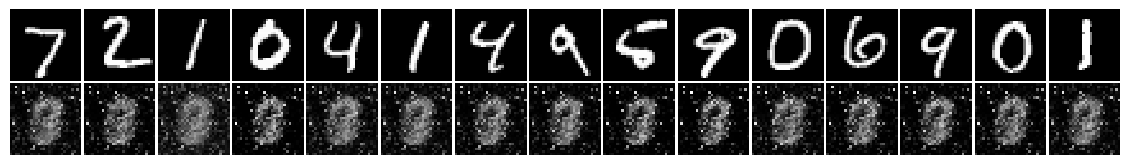

epoch 1 | iter 15 | loss 0.07896
epoch 1 | iter 20 | loss 0.07123


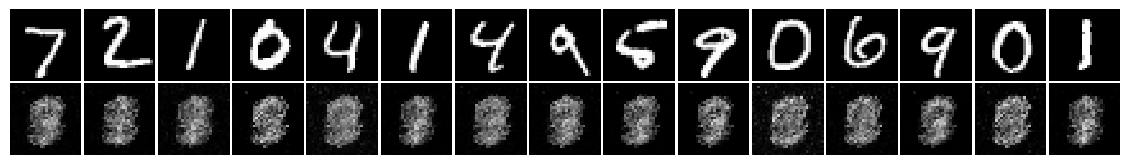

epoch 1 | iter 25 | loss 0.06510
epoch 1 | iter 30 | loss 0.06015


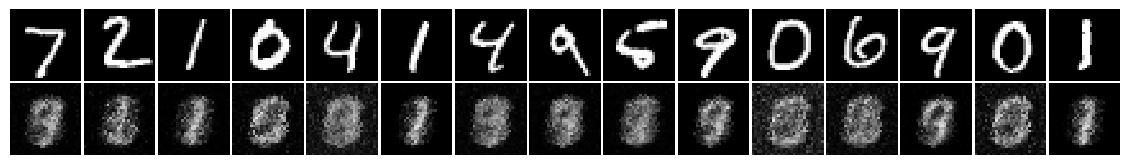

epoch 1 | iter 35 | loss 0.05835
epoch 1 | iter 40 | loss 0.05300


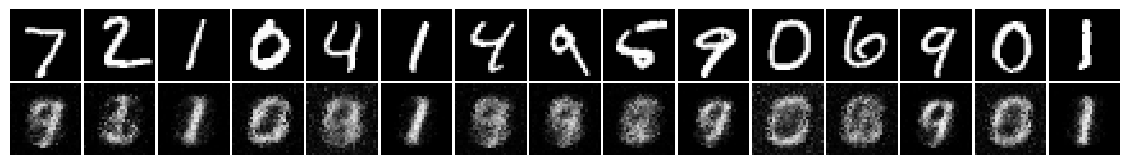

epoch 1 | iter 45 | loss 0.05026
epoch 1 | iter 50 | loss 0.04611


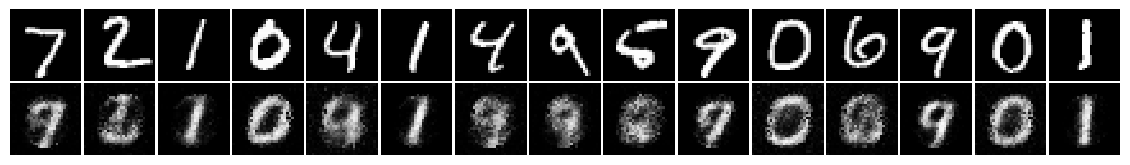

epoch 1 | iter 55 | loss 0.04244
epoch 1 | iter 60 | loss 0.04039


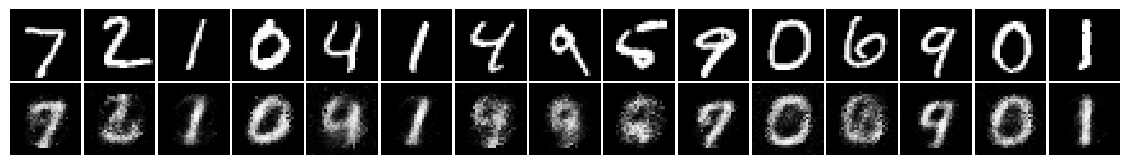

epoch 1 | iter 65 | loss 0.03811
epoch 1 | iter 70 | loss 0.03620


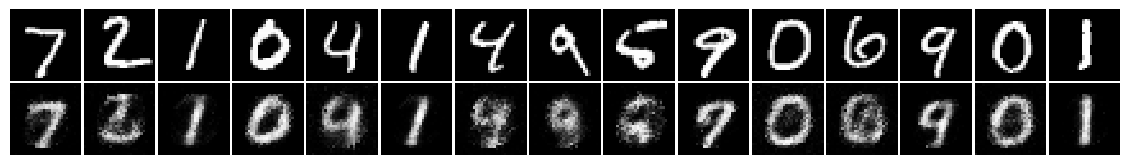

epoch 1 | iter 75 | loss 0.03554
epoch 1 | iter 80 | loss 0.03384


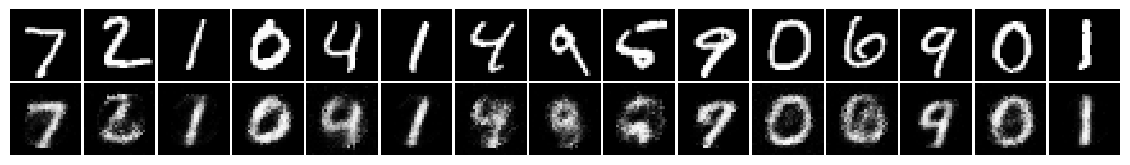

epoch 1 | iter 85 | loss 0.03176
epoch 1 | iter 90 | loss 0.03102


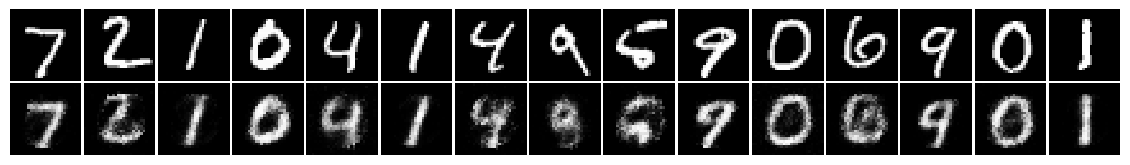

epoch 1 | iter 95 | loss 0.02979
epoch 1 | iter 100 | loss 0.02896


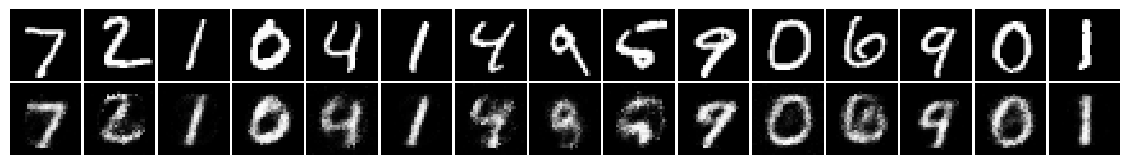

epoch 1 | iter 105 | loss 0.02827
epoch 1 | iter 110 | loss 0.02703


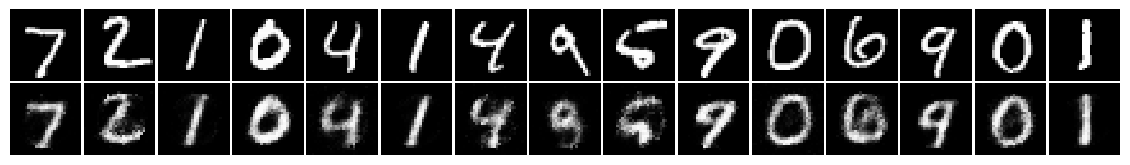

epoch 1 | iter 115 | loss 0.02623
epoch 1 | iter 120 | loss 0.02618


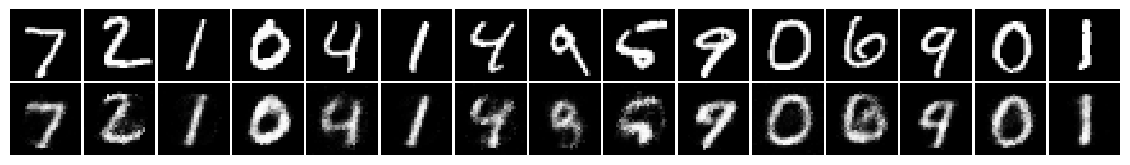

epoch 1 | iter 125 | loss 0.02573
epoch 1 | iter 130 | loss 0.02438


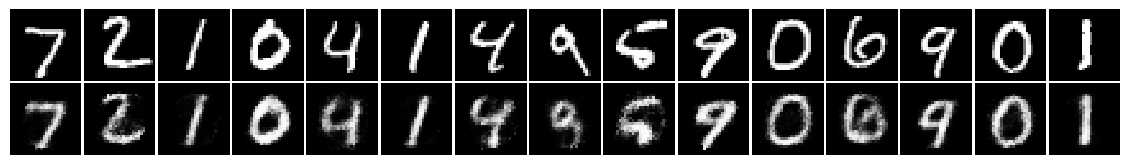

epoch 1 | iter 135 | loss 0.02392
epoch 1 | iter 140 | loss 0.02361


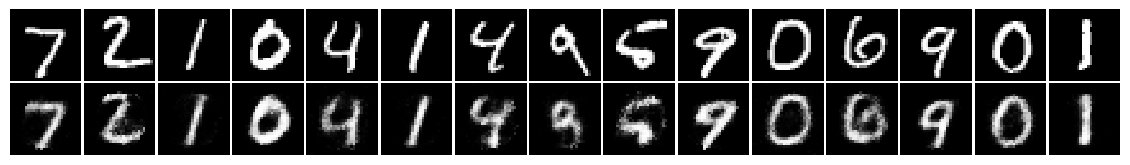

epoch 1 | iter 145 | loss 0.02305
epoch 1 | iter 150 | loss 0.02312


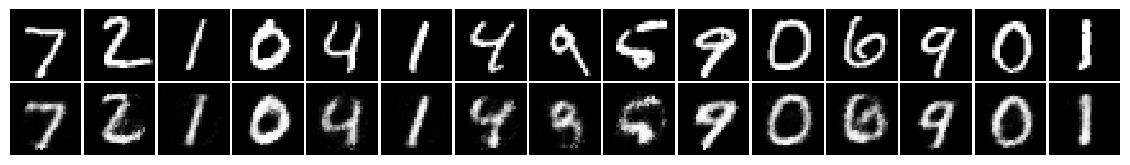

epoch 1 | iter 155 | loss 0.02269
epoch 1 | iter 160 | loss 0.02133


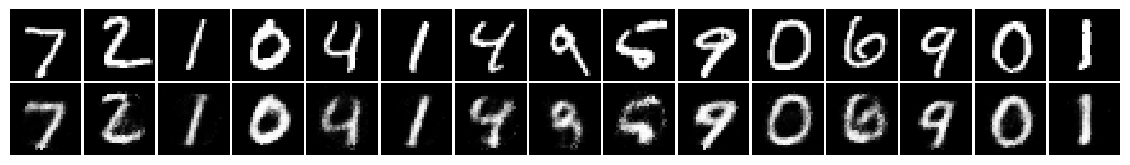

epoch 1 | iter 165 | loss 0.02183
epoch 1 | iter 170 | loss 0.02141


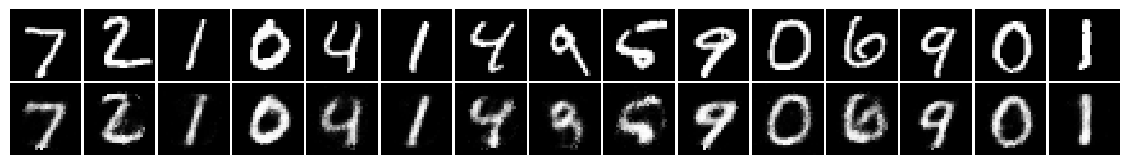

epoch 1 | iter 175 | loss 0.02089
epoch 1 | iter 180 | loss 0.02098


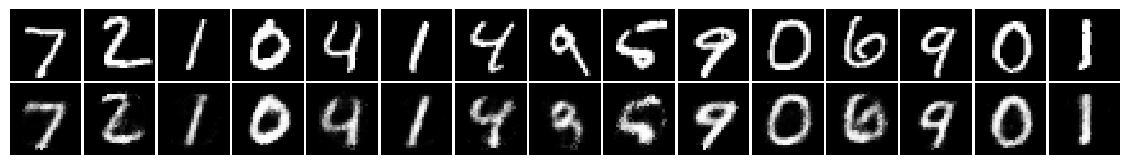

epoch 1 | iter 185 | loss 0.02051
epoch 1 | iter 190 | loss 0.01988


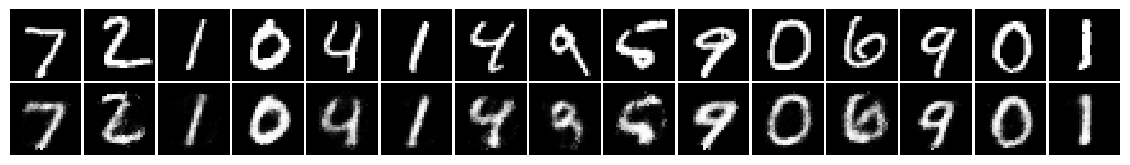

epoch 1 | iter 195 | loss 0.01991
epoch 1 | iter 200 | loss 0.01956


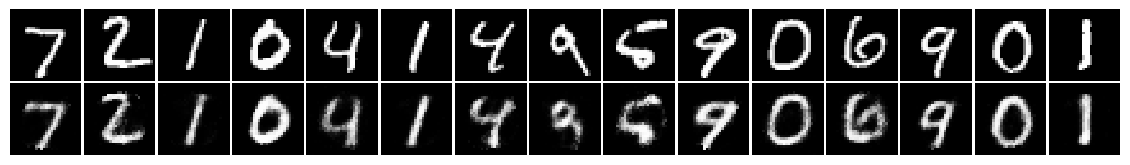

epoch 1 | iter 205 | loss 0.02028
epoch 1 | iter 210 | loss 0.01854


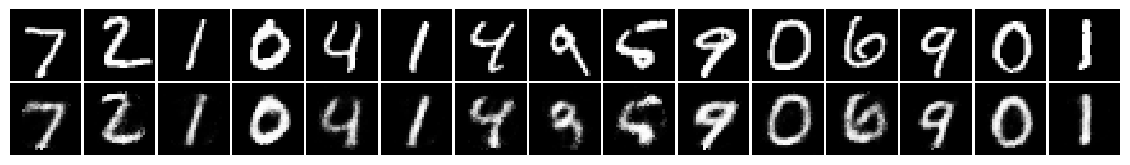

epoch 1 | iter 215 | loss 0.01897
epoch 1 | iter 220 | loss 0.01843


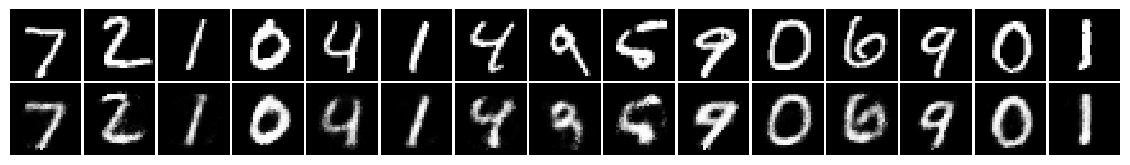

epoch 1 | iter 225 | loss 0.01835
epoch 1 | iter 230 | loss 0.01840


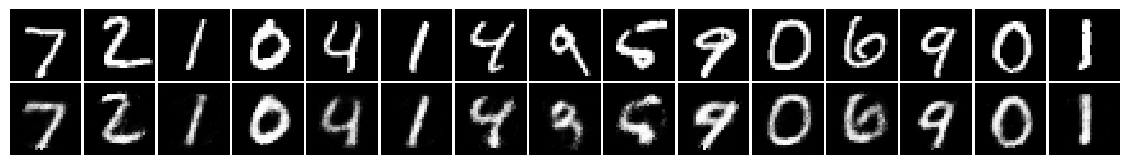

epoch 1 | iter 235 | loss 0.01917
epoch 1 | iter 240 | loss 0.01831


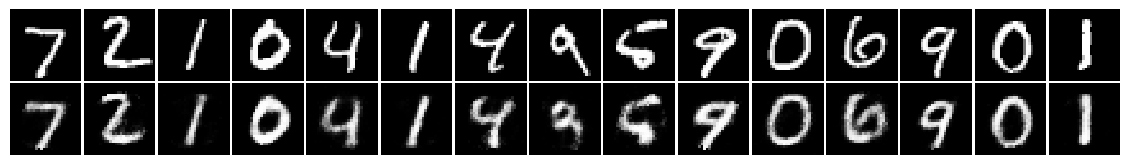

epoch 1 | iter 245 | loss 0.01841
epoch 1 | iter 250 | loss 0.01876


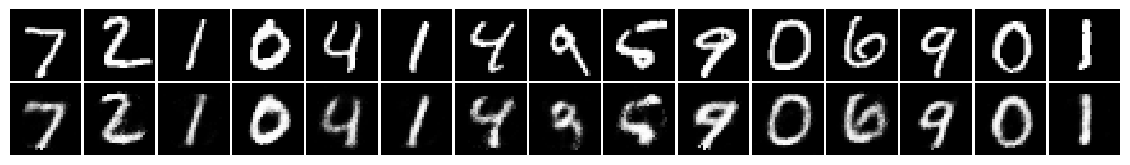

epoch 1 | iter 255 | loss 0.01757
epoch 1 | iter 260 | loss 0.01745


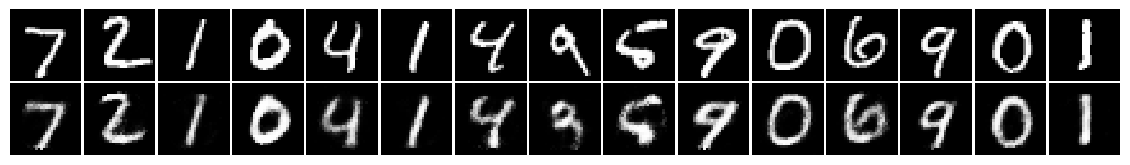

epoch 1 | iter 265 | loss 0.01718
epoch 1 | iter 270 | loss 0.01744


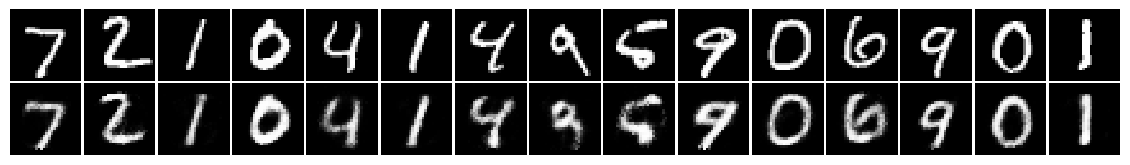

epoch 1 | iter 275 | loss 0.01709
epoch 1 | iter 280 | loss 0.01721


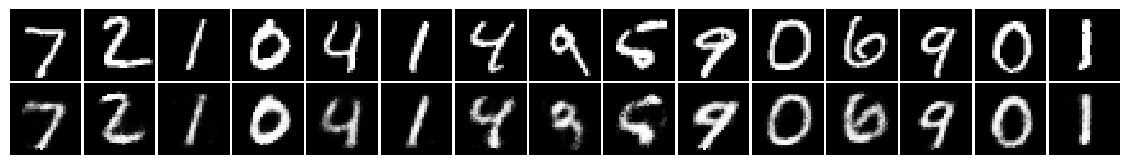

epoch 1 | iter 285 | loss 0.01683
epoch 1 | iter 290 | loss 0.01710


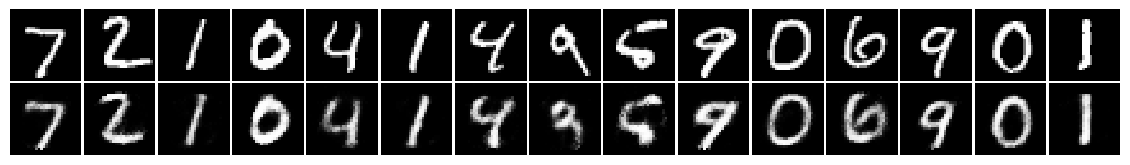

epoch 1 | iter 295 | loss 0.01732
epoch 1 | iter 300 | loss 0.01651


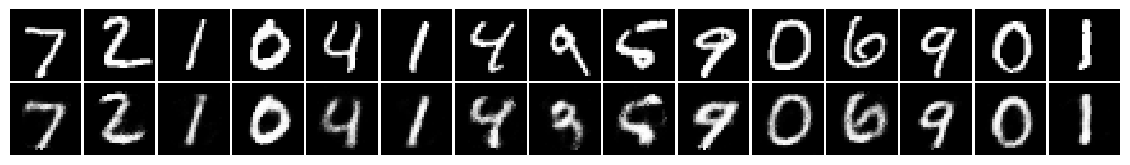

epoch 1 | iter 305 | loss 0.01640
epoch 1 | iter 310 | loss 0.01727


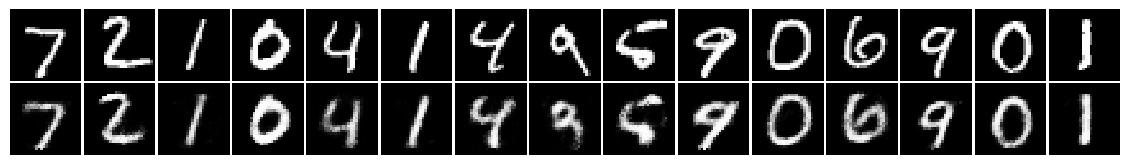

epoch 1 | iter 315 | loss 0.01681
epoch 1 | iter 320 | loss 0.01692


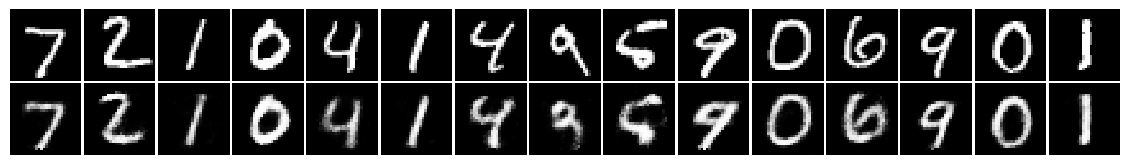

epoch 1 | iter 325 | loss 0.01641
epoch 1 | iter 330 | loss 0.01676


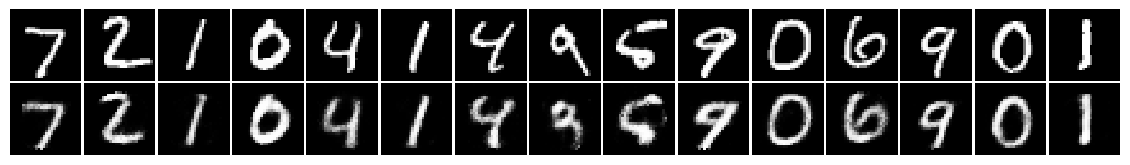

epoch 1 | iter 335 | loss 0.01680
epoch 1 | iter 340 | loss 0.01660


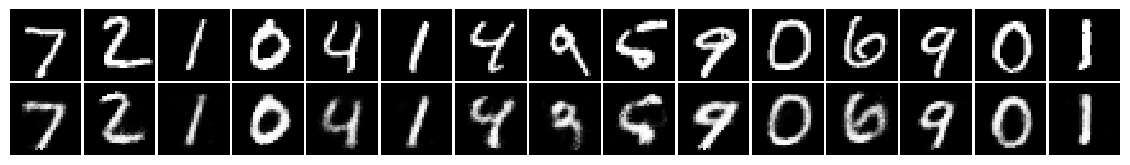

epoch 1 | iter 345 | loss 0.01694
epoch 1 | iter 350 | loss 0.01650


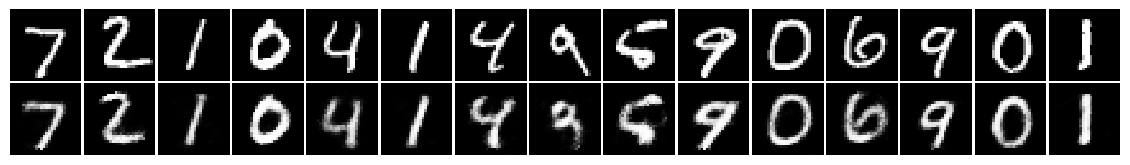

epoch 1 | iter 355 | loss 0.01653
epoch 1 | iter 360 | loss 0.01620


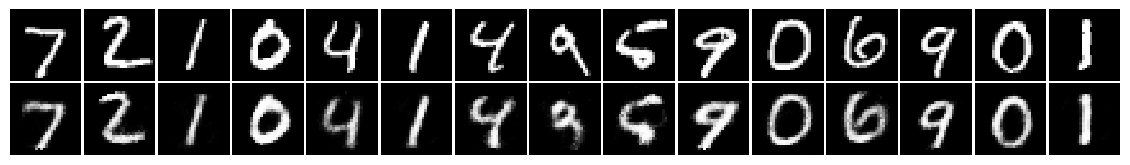

epoch 1 | iter 365 | loss 0.01605
epoch 1 | iter 370 | loss 0.01590


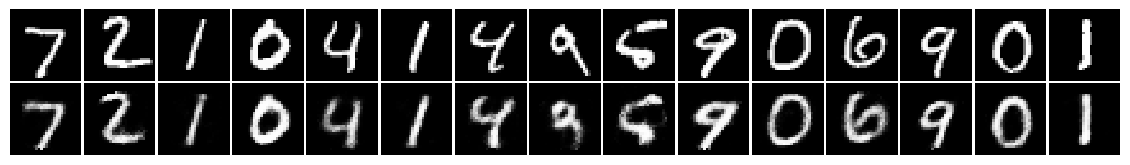

epoch 1 | iter 375 | loss 0.01642
epoch 1 | iter 380 | loss 0.01549


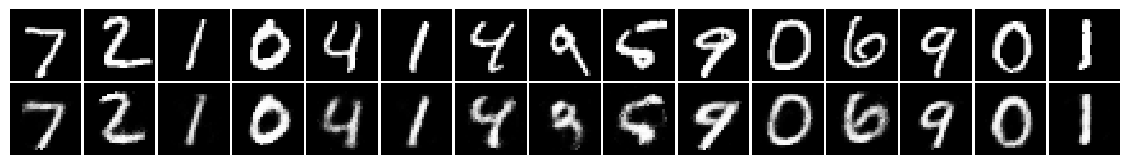

epoch 1 | iter 385 | loss 0.01569
epoch 1 | iter 390 | loss 0.01619


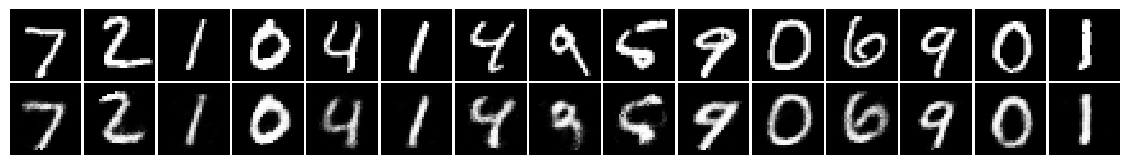

epoch 1 | iter 395 | loss 0.01548
epoch 1 | iter 400 | loss 0.01501


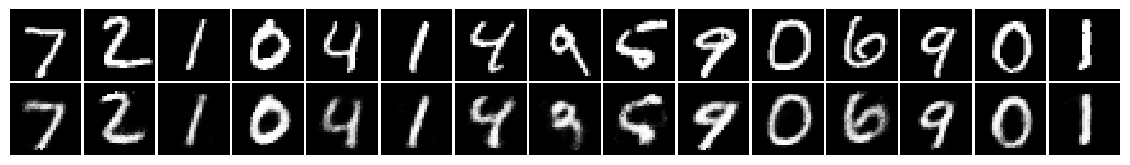

epoch 1 | iter 405 | loss 0.01619
epoch 1 | iter 410 | loss 0.01545


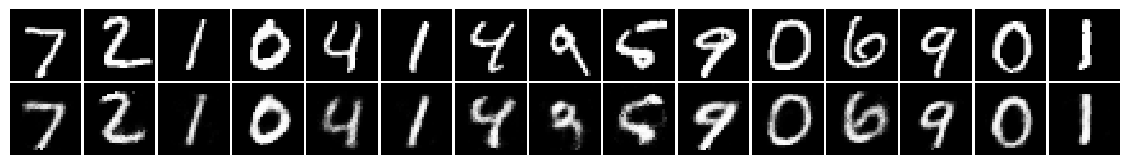

epoch 1 | iter 415 | loss 0.01532
epoch 1 | iter 420 | loss 0.01573


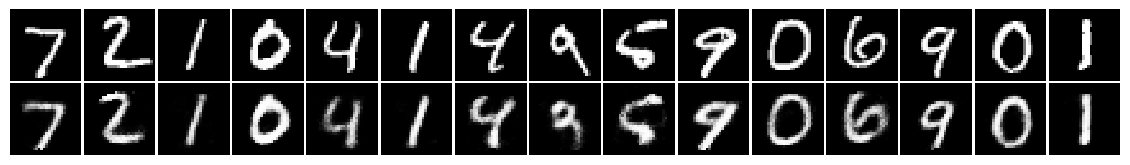

epoch 1 | iter 425 | loss 0.01562
epoch 1 | iter 430 | loss 0.01538


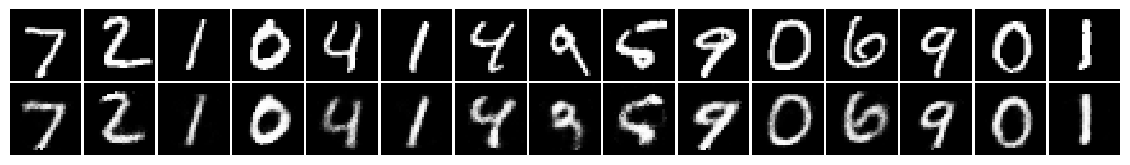

epoch 1 | iter 435 | loss 0.01483
epoch 1 | iter 440 | loss 0.01569


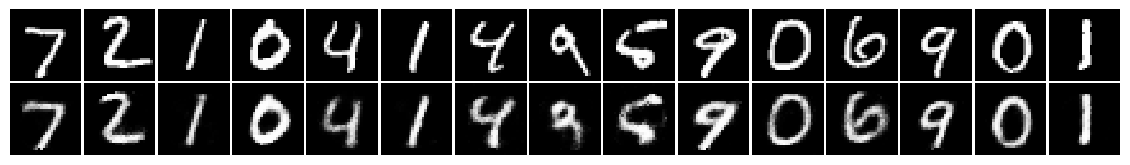

epoch 1 | iter 445 | loss 0.01471
epoch 1 | iter 450 | loss 0.01517


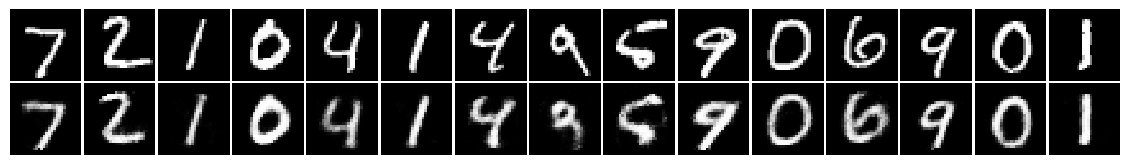

epoch 1 | iter 455 | loss 0.01503
epoch 1 | iter 460 | loss 0.01509


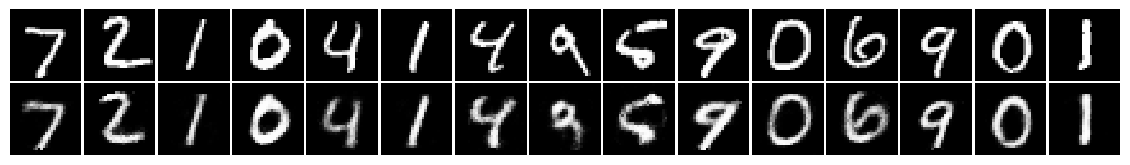

epoch 1 | iter 465 | loss 0.01486
epoch 1 | iter 470 | loss 0.01558


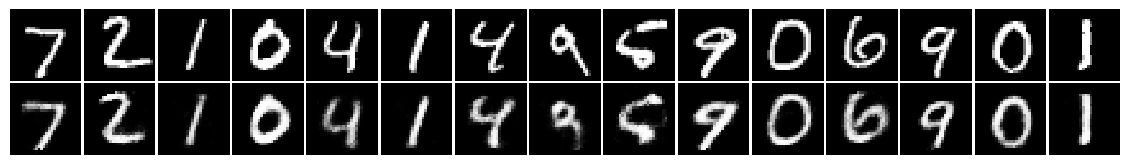

epoch 2 | iter 475 | loss 0.01519
epoch 2 | iter 480 | loss 0.01437


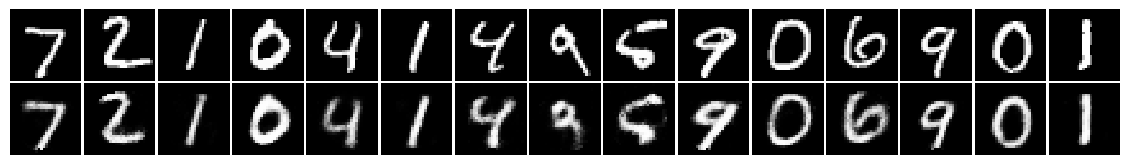

epoch 2 | iter 485 | loss 0.01471
epoch 2 | iter 490 | loss 0.01403


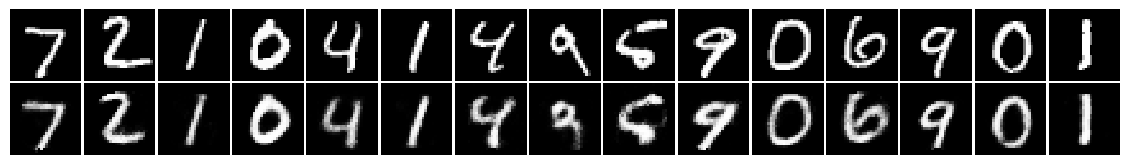

epoch 2 | iter 495 | loss 0.01440
epoch 2 | iter 500 | loss 0.01437


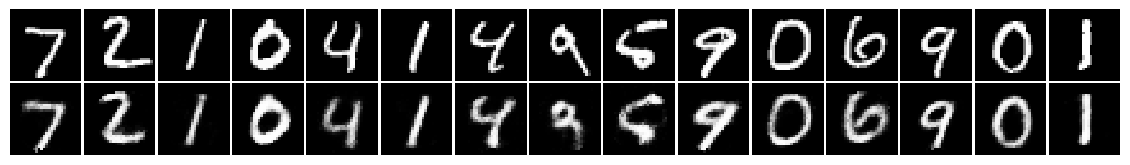

In [18]:
# we will be training the model for 500 iterations

ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=20)

train_ae(train_dl, valid_dl, ae, 50, 500)

## Training Vanilla Variational Auto Encoder

Now we will reuse Encoder and Decoder modules from above to build a simple variational auto encoder 

In [19]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int, z_dim: int):
        super().__init__()
        
        self.enc = Encoder(inp_shape, hidden_dim, out_dim)
        self.dec = Decoder(inp_shape, hidden_dim, out_dim)
        
        self.mu     = nn.Linear(out_dim, z_dim)
        self.logvar = nn.Linear(out_dim, z_dim)
        
        self.fc = nn.Linear(z_dim, out_dim)
        
        init_weights(self)
        
    def encode(self, x):
        """This function takes x and produces mean and log(variance) for approximate posterior Q(z|x)"""
        
        enc = self.enc(x)
        
        mu, logvar = self.mu(enc), self.logvar(enc)
        
        return mu, logvar
        
    def sample_z(self, mu, logvar):
        """This function takes mean and log(variance) and applies reparametrization trick."""
        
        eps = torch.rand_like(mu)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        """This function accepts z - latent vector and produces reconstruction of original input."""
        
        return self.dec(self.fc(z))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)

In [20]:
m = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
m

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

In [21]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    """This function defines ELBO loss, KL DIV + RECONSTRUCTION."""
    
    recon_loss = nn.functional.mse_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

def train_vae(train_dl: DataLoader, 
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int,
              max_iters: int = -1):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 100
    
    model = model.cuda()
    
    model.train()
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, y in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()

            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar, alpha=1, beta=1)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f ' % 
                      (epoch + 1, i + 1, acc_loss / LOG_INTERVAL, acc_kld_loss / LOG_INTERVAL, acc_recon_loss / LOG_INTERVAL))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return

epoch 1 | iter 20 | loss 95.70663 | KL loss 4.27766 | recon loss 91.42897 
epoch 1 | iter 40 | loss 49.70225 | KL loss 1.71398 | recon loss 47.98827 
epoch 1 | iter 60 | loss 39.91640 | KL loss 2.66930 | recon loss 37.24710 
epoch 1 | iter 80 | loss 34.66262 | KL loss 3.20730 | recon loss 31.45532 
epoch 1 | iter 100 | loss 31.86380 | KL loss 3.56522 | recon loss 28.29858 


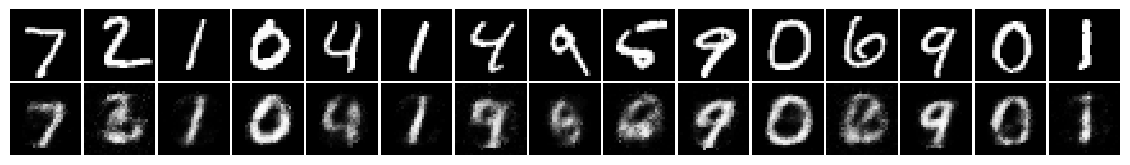

epoch 1 | iter 120 | loss 29.53414 | KL loss 3.81433 | recon loss 25.71981 
epoch 1 | iter 140 | loss 28.23004 | KL loss 3.99701 | recon loss 24.23304 
epoch 1 | iter 160 | loss 27.53556 | KL loss 4.16322 | recon loss 23.37233 
epoch 1 | iter 180 | loss 26.23447 | KL loss 4.27319 | recon loss 21.96128 
epoch 1 | iter 200 | loss 25.70368 | KL loss 4.31593 | recon loss 21.38775 


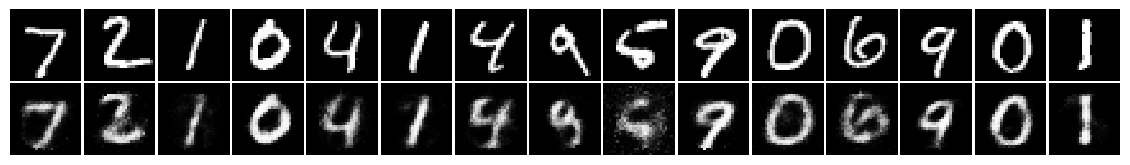

epoch 1 | iter 220 | loss 24.89235 | KL loss 4.40957 | recon loss 20.48278 
epoch 1 | iter 240 | loss 24.73300 | KL loss 4.48605 | recon loss 20.24695 
epoch 1 | iter 260 | loss 24.05719 | KL loss 4.45568 | recon loss 19.60151 
epoch 1 | iter 280 | loss 23.69458 | KL loss 4.49186 | recon loss 19.20272 
epoch 1 | iter 300 | loss 23.46165 | KL loss 4.52235 | recon loss 18.93930 


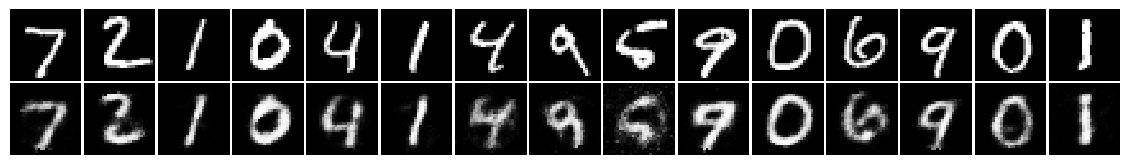

epoch 1 | iter 320 | loss 23.23654 | KL loss 4.56928 | recon loss 18.66726 
epoch 1 | iter 340 | loss 22.82413 | KL loss 4.50084 | recon loss 18.32329 
epoch 1 | iter 360 | loss 22.50572 | KL loss 4.54786 | recon loss 17.95786 
epoch 1 | iter 380 | loss 22.29985 | KL loss 4.55401 | recon loss 17.74585 
epoch 1 | iter 400 | loss 22.45135 | KL loss 4.55935 | recon loss 17.89200 


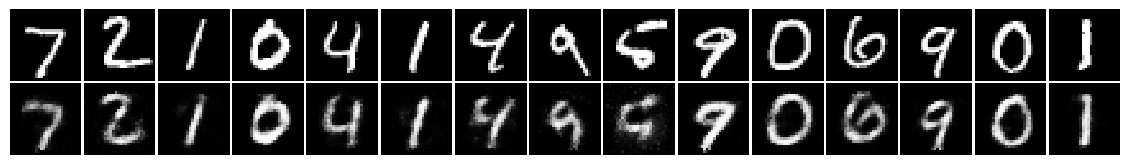

epoch 1 | iter 420 | loss 22.26460 | KL loss 4.61431 | recon loss 17.65029 
epoch 1 | iter 440 | loss 22.09690 | KL loss 4.62371 | recon loss 17.47319 
epoch 1 | iter 460 | loss 22.14144 | KL loss 4.67260 | recon loss 17.46883 
epoch 2 | iter 480 | loss 21.85828 | KL loss 4.65796 | recon loss 17.20033 
epoch 2 | iter 500 | loss 21.63771 | KL loss 4.62016 | recon loss 17.01754 


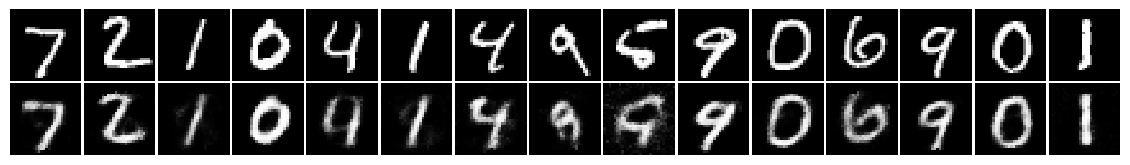

In [22]:
# we will be training the model for 500 iterations

vae = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=20)

train_vae(train_dl, valid_dl, vae, 50, 500)

### Visualizing Latent Space

In this section we will work through several visualizations of above models to develop good intuition how these models work.  

In all below cases we will be using models with 2D latent space since its directly plottable without need of dimensionality reduction techniques, such as PCA. 

Besides, we will use pre-trained model weights because 2D latent space model training requires approx. 50 epochs on the data that would take long time to do it here.



In [23]:
# loading pre-trained Auto Encoder with 2D latent space

ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=2)
ae.load_state_dict(torch.load('./ae-20'))
ae.eval()

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

We will start by visualizing the clusters of digits by plotting latent vectors of datapoints from validation set.

In [24]:
# here we will go over validation set and generate latent representation of every data point by using encoder part 
# of the model. X and Y coordinates of this latent vectors, along with the label are stored in Dataframe.

z, labels = [], []
for i, (x, y) in enumerate(valid_dl):
    mu = ae.ae[0](x).detach()
    z.append(mu)
    labels.append(y)
z = torch.cat(z, dim=0)
labels = torch.cat(labels, dim=0)

df = pd.DataFrame({'x': z[:,0].numpy(), 
                   'y': z[:,1].numpy(),
                   'label': labels.numpy()})

df.head()

x         y  label
0  1.105610  4.956746      7
1 -0.581305 -0.078693      2
2 -6.466476  6.207766      1
3  1.150499 -0.204559      0
4  1.584186  2.257911      4

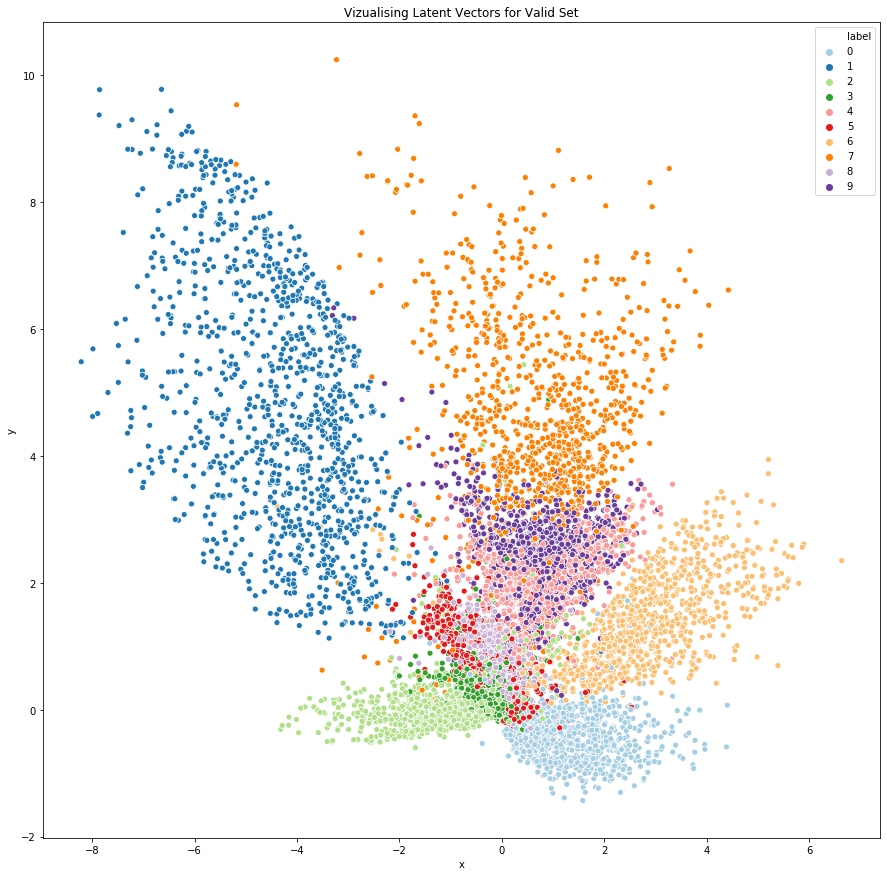

In [25]:
# plotting the dataframe by assigning different color to different digit (label)

plt.figure(figsize=(15, 15))
sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
plt.title('Vizualising Latent Vectors for Valid Set');

Now we will do the same visualization for variational auto-encoder

In [33]:
# loading pre-trained Variational Auto Encoder with 2D latent space

vae = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
vae.load_state_dict(torch.load('./vae-60'))
vae.eval()

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

In [27]:
def viz_vae_clusters(vae: nn.Module):

    vae.cuda()
    z, labels = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.cuda()
            mu, _ = vae.encode(x)
            z.append(mu.cpu())
            labels.append(y)
    z = torch.cat(z, dim=0)
    labels = torch.cat(labels, dim=0)

    df = pd.DataFrame({'x': z[:,0].numpy(), 
                  'y': z[:,1].numpy(),
                  'label': labels.numpy()})

    plt.figure(figsize=(15, 15))
    sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
    plt.title('Vizualising Latent Vectors for Valid Set');

As you will see from below plot, point cloud of latent vectors has circular shape centered at origin as opposed to 
Auto Encoder case. This behaviour is imposed by KL Divergence component of the loss, that forces latent distribution to be close to the isotropic Gaussian.

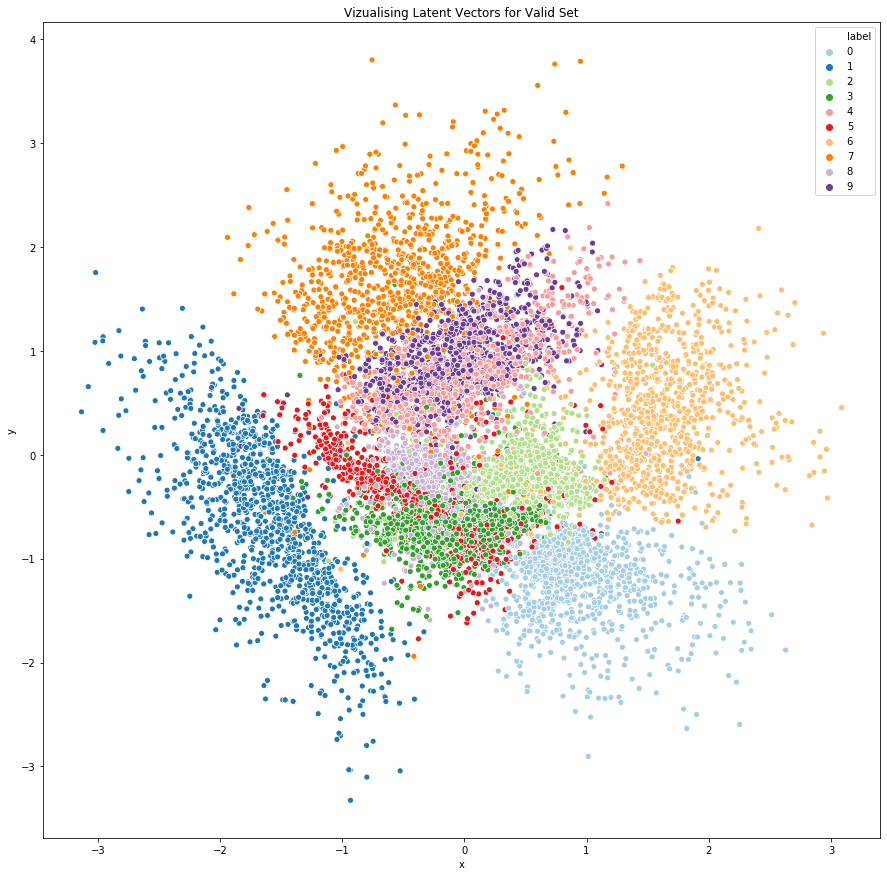

In [28]:
viz_vae_clusters(vae)

Now we will see what happens if we remove KL Divergence term and only use reconstruction loss.

In [29]:
# loading trained Variational AutoEncoder with 2D latent space and without KL component

vae_kl = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
vae_kl.load_state_dict(torch.load('./vae-60-kl0'))
vae_kl.eval()

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

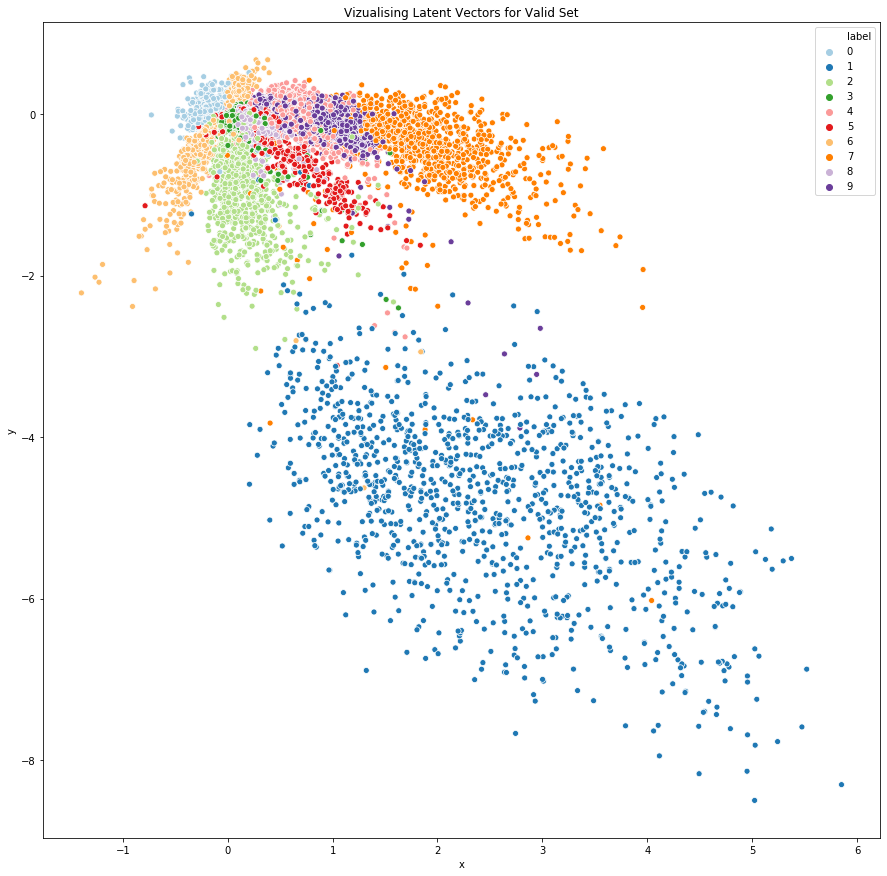

In [30]:
viz_vae_clusters(vae_kl)

Now we will show that latent space of Variational Auto-Encoder is continuous, i.e. close latent vectors produce similar looking images at the output.

We will do it by visualizing whole 2D space at once (run the below cell to see what it means).

We will exploit the fact that our latent vectors are distributed somewhat similar to 2D isotropic gaussian centered at origin (refer above plots). Having said this, we need to generate 2D meshgrid where distribution of points correspond to 2D Gaussian.


To do this, we gonna first generate 2D meshgrid in $[0, 1]^2$ unit square and use inverse CDF (Comulative Distribution Function) of Gaussian to translate our meshgrid to the latent space.

Finally, we decode every point in latent space and visualize output images as 2D plot.



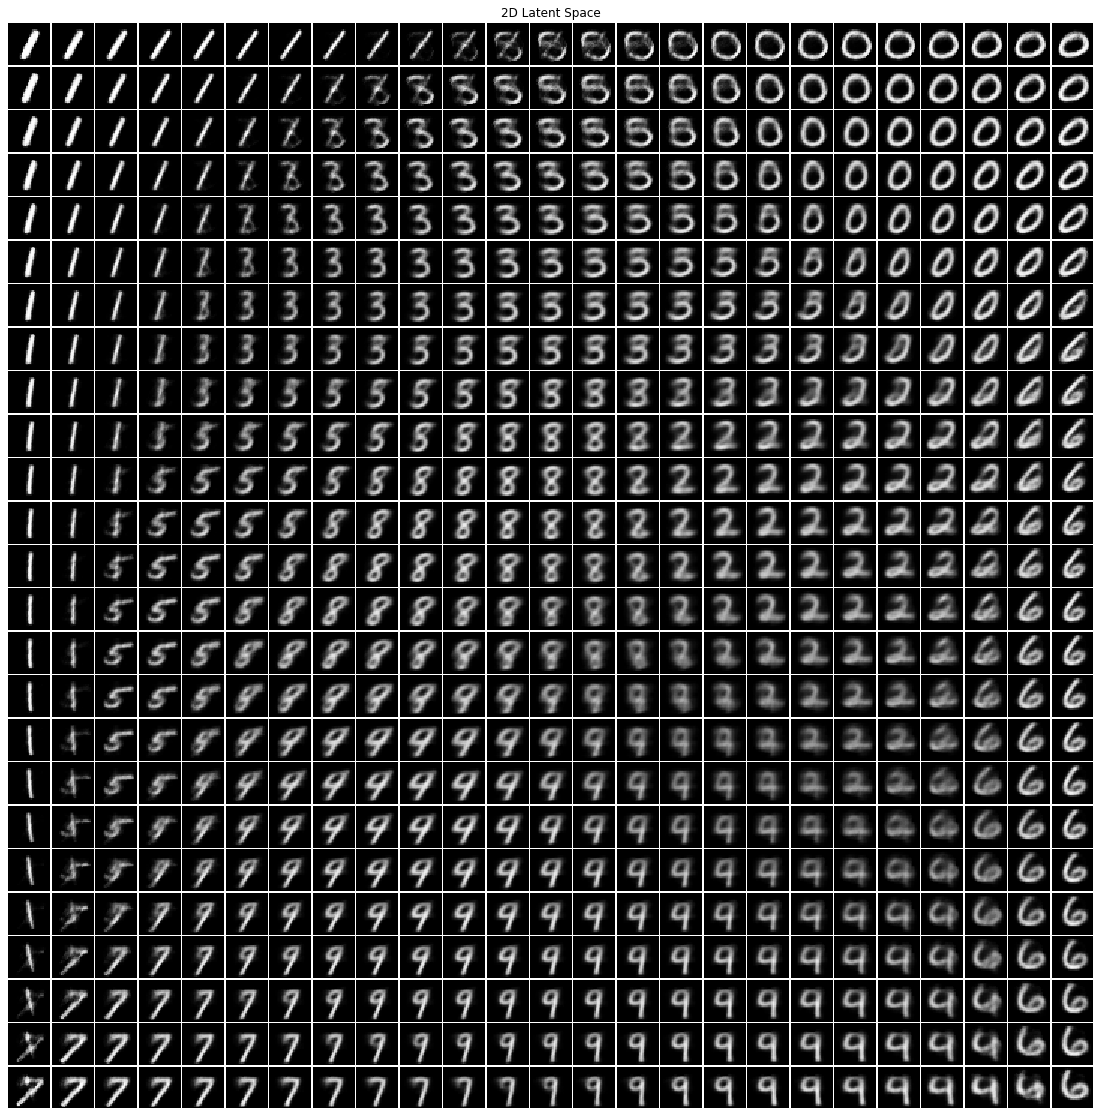

In [31]:
def draw_mnist_manifold_vae(model: nn.Module, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = ndist.ppf(np.linspace(0.05, 0.95, size))
    y_axes = ndist.ppf(np.linspace(0.05, 0.95, size))

    # preparing input to decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # decoding latent vectors
    preds = model.decode(z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()

draw_mnist_manifold_vae(vae.cpu(), size=25);

Doing similar visualization on Auto Encoder produces bad result, because the latent space usually isn't continuous.

More specifically, in some regions of space we get outputs that <b>don't represent valid digits</b>.

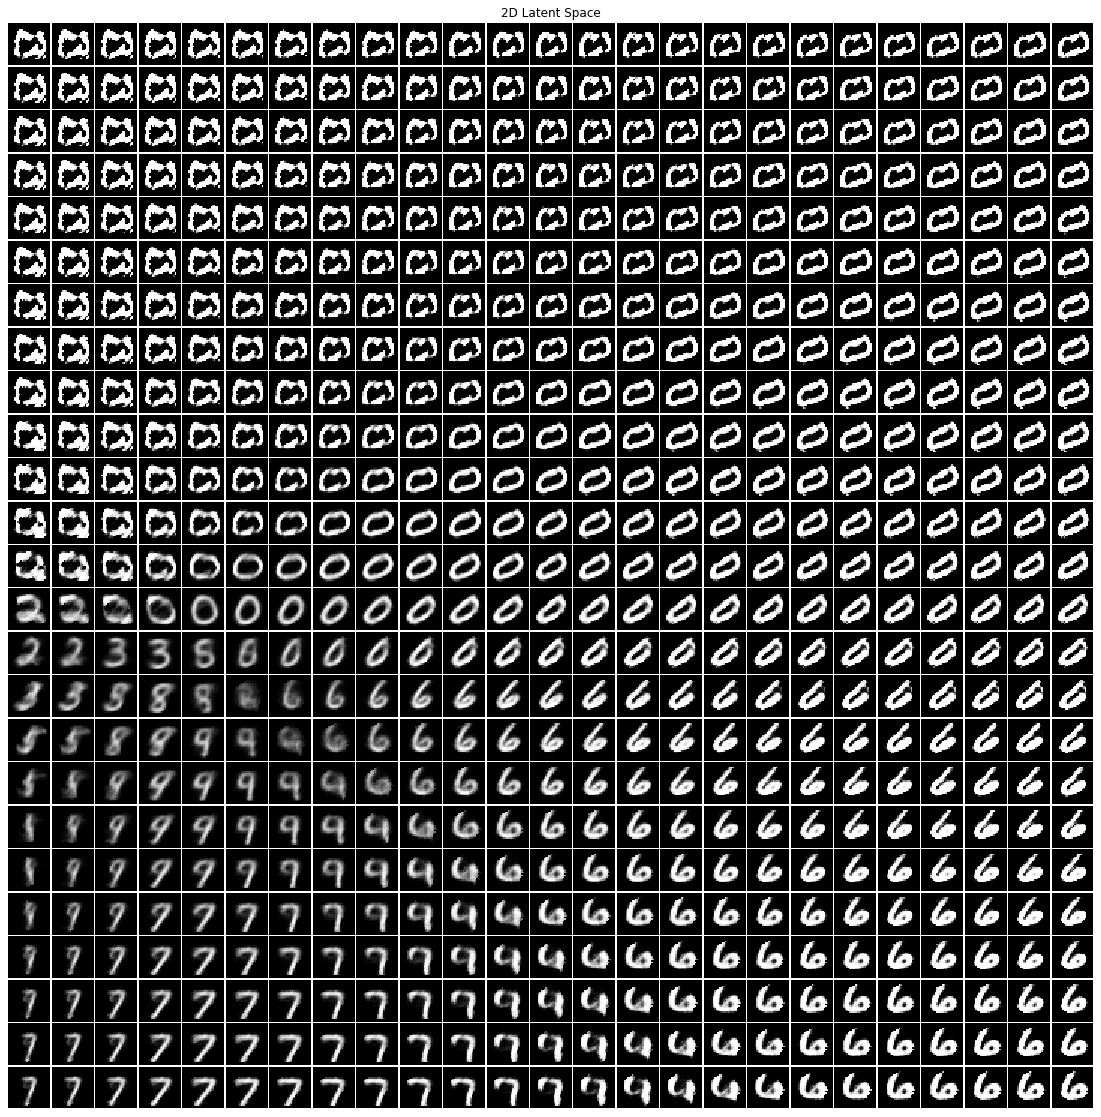

In [32]:
def draw_mnist_manifold_ae(model: nn.Module, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = np.linspace(-8, 6, size)
    y_axes = np.linspace(-1.5, 10, size)

    # assembling the latent vector of shape (size^2, 2) to be fed into the decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # generating predictions
    preds = model.ae[1](z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()
    
draw_mnist_manifold_ae(ae.cpu(), 25)

## Sampling from VAE

One of the goals of generative models is being able to effectively sample from learned data distribution.  

In case of VAE, we take trained model, remove its encoder, and use decoder to transform gaussian noise into data point.

In [34]:
# generate 100 gaussian noise vectors

z = torch.empty(100, 2).normal_(0, 1)
z.shape

torch.Size([100, 2])

In [35]:
# decode the noise vectors

images = vae.decode(z)

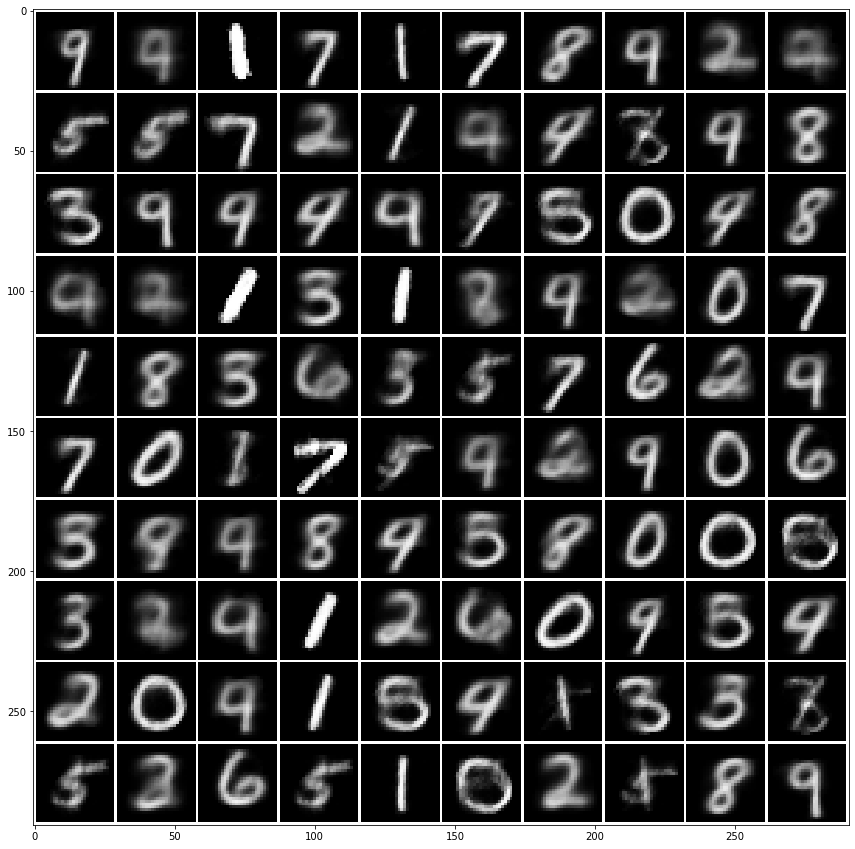

In [36]:
# plot the result

grid = make_grid(images, pad_value=1, padding=1, nrow=10)[0].detach().numpy()
plt.figure(figsize=(15, 15))
plt.imshow(grid, cmap='gray');

Continuity of latent space implies certain <b>robustness</b> agains noise.  

We can take latent vector corresponding to some digit, add small noise to it and still get output very similar to that digit.

In [37]:
# here we calculate average latent vector for every digit 0-9.
# average is taken to make sure we have representative vector, i.e we are somewhere close to the centroid of that digit's cluster.

locs = [torch.zeros(1, 1, 2) for _ in range(10)] # list for keeping latent vectors corresponding to digits 0-9
locs_cnt = [0] * 10 # list for keeping counts of latent vectors per digits. 

for i, (x, y) in enumerate(valid_dl.dataset):
    mu, _ = vae.encode(x.unsqueeze(0))
    locs[y] += mu
    locs_cnt[y] += 1
    if i > 500:
        break
        
for i in range(len(locs)): locs[i] /= locs_cnt[i]

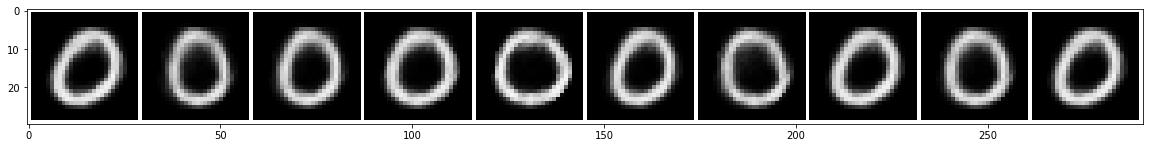

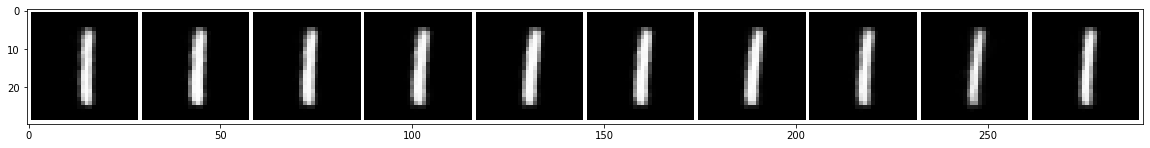

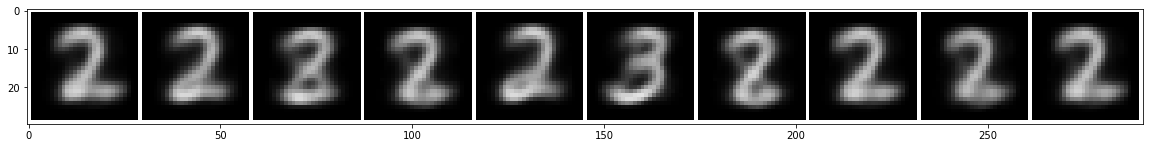

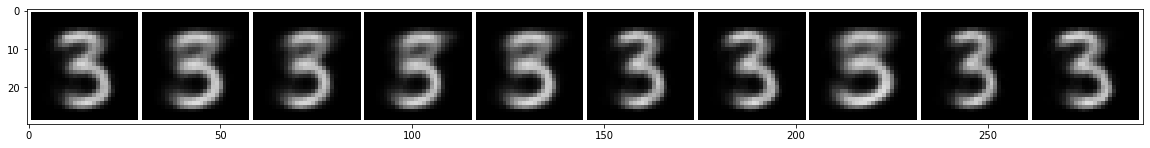

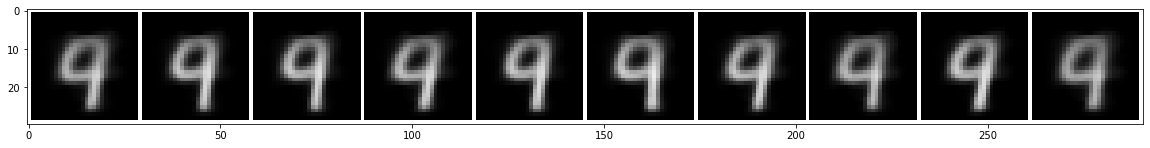

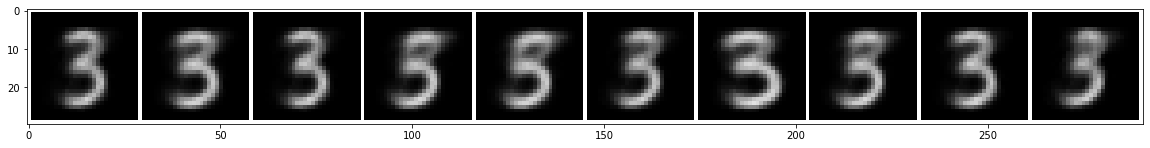

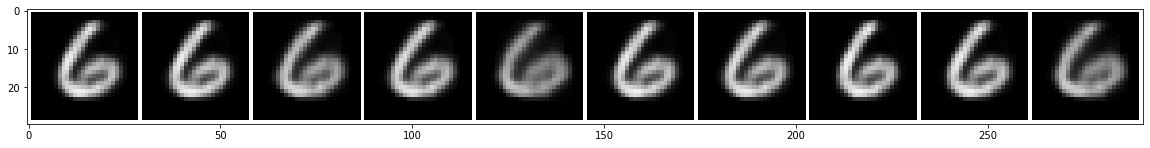

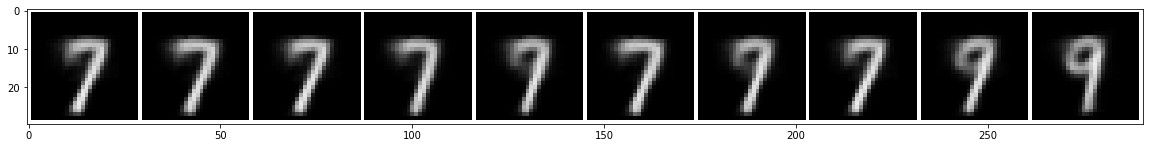

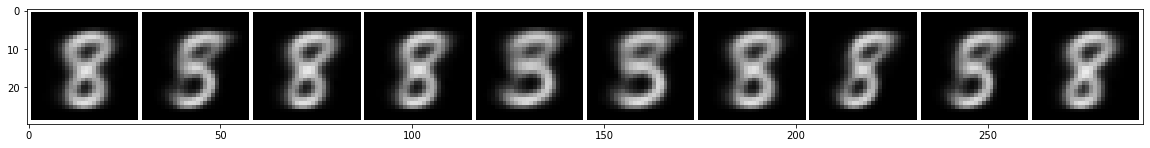

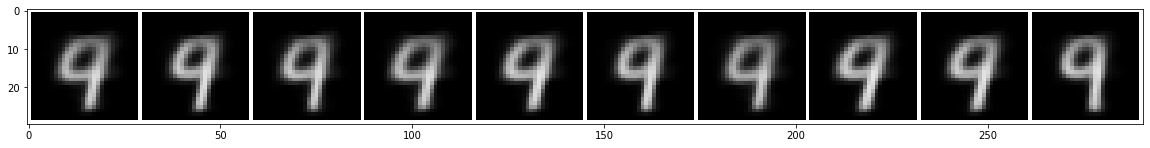

In [38]:
# we show how to generate same digit in different "handwriting" by taking average vector of that 
# digit and adding small noise. 

for i in range(10):
    x_recon = []
    for j in range(10):
        loc = locs[i].clone()
        loc += torch.empty_like(loc).normal_()/8
        x_recon.append(vae.decode(loc))
        
    x_recon = torch.cat(x_recon)
    
    grid = make_grid(x_recon, pad_value=1, padding=1, nrow=20)[0].detach().numpy()
    plt.figure(figsize=(20, 5))
    plt.imshow(grid, cmap='gray')
    plt.show()